## Documents Extraction and Processing

Lets first obtain the file that maps the tickers with the CIKs

In [1]:
import requests
import json
from pathlib import Path
import os

# --- Configuration (from previous step) ---
HEADERS = {
    "User-Agent": "EdgarTutorial/1.0 (YourName your.email@domain.com)" 
}
TICKER_CIK_URL = "https://www.sec.gov/files/company_tickers.json"
OUTPUT_FILE = Path("sec_data/company_tickers.json")

# Ensure directory exists
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
# ----------------------------------------

# 1. Download the JSON data
print("Downloading CIK-Ticker map...")
response = requests.get(TICKER_CIK_URL, headers=HEADERS, timeout=15)
response.raise_for_status()
raw_data = response.json() # Load into Python dictionary

# 2. Open the file and use json.dump() with indent=4
print(f"Saving JSON in readable format to {OUTPUT_FILE.absolute()}...")

# Use 'w' mode to write the file
with open(OUTPUT_FILE, 'w') as f:
    # Key Fix: The 'indent=4' parameter tells the JSON module to format the output 
    # with 4 spaces for each level of nesting, adding line breaks automatically.
    json.dump(raw_data, f, indent=4) 

print("✅ JSON saved successfully with proper line breaks and indentation.")

# --- Optional: Print a Snippet to Console (Also Pretty-Printed) ---
# If you want to print to the console instead of a file, use json.dumps()
print("\n--- Console Snippet (Pretty-Printed) ---")
# Print the first 3 key-value pairs from the dictionary
keys = list(raw_data.keys())
snippet = {k: raw_data[k] for k in keys[:3]}

# Use json.dumps() with indent=2 to format the string output
pretty_string = json.dumps(snippet, indent=2)
print(pretty_string)

Saving JSON in readable format to /home/alvar/CascadeProjects/windsurf-project/RAG/notebooks/sec_data/company_tickers.json...
✅ JSON saved successfully with proper line breaks and indentation.

--- Console Snippet (Pretty-Printed) ---
{
  "0": {
    "cik_str": 1045810,
    "ticker": "NVDA",
    "title": "NVIDIA CORP"
  },
  "1": {
    "cik_str": 320193,
    "ticker": "AAPL",
    "title": "Apple Inc."
  },
  "2": {
    "cik_str": 789019,
    "ticker": "MSFT",
    "title": "MICROSOFT CORP"
  }
}


### Vanguard Index Funds

In [2]:
import pandas as pd
from io import StringIO
from edgar import Company, set_identity
from pathlib import Path


set_identity("luis.alvarez.conde@alumnos.upm.es")

ticker = "VOO"
fund = Company(ticker)
all_filings = fund.get_filings(form="N-CSR")

if all_filings:
    latest_date = max(f.filing_date for f in all_filings)
    
# Filter the list to include only filings from that latest date
latest_filings = [f for f in all_filings if f.filing_date == latest_date]
path = Path("edgar_output")
path.mkdir(exist_ok=True)
print(f"\n--- Latest Filings Found ({latest_date}) ---")
step = 0
for f in latest_filings:
    print(f" - {f.form} | Accession: {f.accession_number} | Date: {f.filing_date}")
    
    # 1. Change the file extension to .html
    output_path = Path("edgar_output/" + ticker + str(step) + ".html")
    
    # 2. Change the method from .text() to .html()
    output_path.write_text(f.html())
    
    print(f"Saved HTML to {output_path.absolute()}")
    step += 1
for f in latest_filings:
    print(f"  - {f.form} | Accession: {f.accession_number} | Date: {f.filing_date}")
    
    output_path = Path("edgar_output/"+ f.accession_number + ".txt")
    
    output_path.write_text(f.text())
    print(f"Saved to {output_path.absolute()}")


--- Latest Filings Found (2025-03-04) ---
 - N-CSR | Accession: 0001104659-25-020311 | Date: 2025-03-04
Saved HTML to /home/alvar/CascadeProjects/windsurf-project/RAG/notebooks/edgar_output/VOO0.html
 - N-CSR | Accession: 0001104659-25-020270 | Date: 2025-03-04
Saved HTML to /home/alvar/CascadeProjects/windsurf-project/RAG/notebooks/edgar_output/VOO1.html
  - N-CSR | Accession: 0001104659-25-020311 | Date: 2025-03-04


Saved to /home/alvar/CascadeProjects/windsurf-project/RAG/notebooks/edgar_output/0001104659-25-020311.txt
  - N-CSR | Accession: 0001104659-25-020270 | Date: 2025-03-04


Saved to /home/alvar/CascadeProjects/windsurf-project/RAG/notebooks/edgar_output/0001104659-25-020270.txt


In [24]:
import re

def extract_fund_by_ticker(full_text, ticker):
    if not full_text or not isinstance(full_text, str):
        return None
        
    safe_ticker = re.escape(str(ticker))
    
    # Find all fund header positions
    # Pattern matches: "Some text (TICKER)" at logical header positions
    header_pattern = r'^.*?\(\s*[A-Z]{3,9}\s*\).*?(?:Annual|Shareholder|Report)'
    
    # Find the start of our target fund
    start_pattern = r'[^\n]*\(\s*' + safe_ticker + r'\s*\).*?(?:Annual|Shareholder|Report)'
    start_match = re.search(start_pattern, full_text, re.MULTILINE | re.IGNORECASE)
    
    if not start_match:
        return None
    
    start_pos = start_match.start()
    
    # Find the next fund header after our target
    # Look for a line with (DIFFERENT_TICKER) after our start position
    next_header_pattern = (
        r'\n.*?\(\s*(?!' + safe_ticker + r'\s*\))[A-Z]{3,9}\s*\)'
        r'.*?(?:Annual|Shareholder|Report)'
    )
    
    next_match = re.search(
        next_header_pattern, 
        full_text[start_pos:], 
        re.MULTILINE | re.IGNORECASE
    )
    
    if next_match:
        # Extract from start to just before next header
        end_pos = start_pos + next_match.start()
        return full_text[start_pos:end_pos].strip()
    else:
        # No next header found, return rest of document
        return full_text[start_pos:].strip()

def extract_performance(fund_chunk):
    if not fund_chunk:
        return None

    # 1. START ANCHOR: The specific question
    # We escape the '?' because it has special meaning in regex
    start_phrase = r"How did the Fund perform during the reporting period\?"

    # 2. END ANCHOR: The NEXT Question (Lookahead)
    # We look for a Newline (\n) followed by "How" or "What" or "Where" and a '?'
    # This stops it from grabbing the "Past 10 Years" section.
    pattern = f"{start_phrase}(.*?)\?"

    match = re.search(pattern, fund_chunk, re.DOTALL | re.IGNORECASE)
    
    if match:
        # .strip() removes the leading/trailing newlines
        return "## How did the Fund perform during the reporting period? \n" + match.group(1).strip()
    
    return None


tickers = ["VFINX", "VOO"]

for t in tickers:
    print(f"\n--- Processing {t} ---")
    chunk = extract_fund_by_ticker(latest_filings[1].text(), t)
    performance_commentary = extract_performance(chunk)
    if chunk:
        print(f"✅ Found {len(chunk)} characters.")
        print(f"{chunk[:80]}")  # Verify the Header
        print(f"End:   ...{chunk[-80:]}") # Verify it didn't run into the next fund\
        print(f"Performance Commentary: {performance_commentary}")
    else:
        print("❌ Not Found")


--- Processing VFINX ---
✅ Found 9656 characters.
Vanguard 500 Index Fund Investor Shares( VFINX) Annual Shareholder Report| Decem
End:   ...oup, Inc. All rights
reserved. Vanguard Marketing Corporation, Distributor. AR40
Performance Commentary: ## How did the Fund perform during the reporting period? 
For the 12 months ended December 31, 2024, the Fund performed
in line with its benchmark, the Standard & Poor's 500 Index. U.S. economic growth hovered around 3% on a year-over-
year basis for much of the period, and consumer price inflation trended lower, falling below 3% in July. The
Federal Reserve began cutting short-term interest rates in September, which boosted stock returns, as did the
prospect of tax cuts and deregulation under the incoming administration. Ten of the benchmark’s 11 industry sectors
recorded positive returns for the 12 months. Information technology, the index’s largest sector by weight, posted
extremely strong results and was by far the greatest contributor to 

For this year, there are two N-CSR that contain the information for all of the VANGUARD INDEX FUNDS. In the next cell, I obtain the name and tickers of each of the funds that compose the trust.

In [ ]:

from typing import List, Dict, Tuple
import re
import os



def extract_performance(fund_chunk):
    if not fund_chunk:
        return None

    # 1. START ANCHOR: The specific question
    # We escape the '?' because it has special meaning in regex
    start_phrase = r"How did the Fund perform during the reporting period\?"

    # 2. END ANCHOR: The NEXT Question (Lookahead)
    # We look for a Newline (\n) followed by "How" or "What" or "Where" and a '?'
    # This stops it from grabbing the "Past 10 Years" section.
    stop_at_gap = r"(?=\n\s\n|$)"

    # 3. COMBINE
    # We match the Start Phrase, then Capture (.*?) everything until the End Anchor
    pattern = f"{start_phrase}{stop_at_gap}"

    match = re.search(pattern, fund_chunk, re.DOTALL | re.IGNORECASE)
    
    if match:
        # .strip() removes the leading/trailing newlines
        return "## How did the Fund perform during the reporting period? \n" + match.group(1).strip()
    
    return None


def extract_table_of_contents(content: str) -> List[Dict[str, str]]:
        """
        Extract fund information from the table of contents.
        Returns list of dicts with fund_name, share_class, and ticker.
        """
        # Find TABLE OF CONTENTS section
        toc_pattern = r'TABLE OF CONTENTS\s*\n(.*?)(?=\n\nVanguard|\Z)'
        toc_match = re.search(toc_pattern, content, re.DOTALL)
        
        if not toc_match:
            return []
        
        toc_content = toc_match.group(1)
        lines = toc_content.strip().split('\n')
        
        funds = []
        current_fund = None
        
        for line in lines:
            line = line.strip()
            if not line:
                continue
            
            # Check if line contains a ticker (format: "Share Class - TICKER")
            ticker_match = re.search(r'-\s*([A-Z]{2,6})\s*$', line)
            
            if ticker_match:
                ticker = ticker_match.group(1)
                share_class = re.sub(r'\s*-\s*[A-Z]{3,6}\s*$', '', line).strip()
                
                if current_fund:
                    funds.append({
                        'fund_name': current_fund,
                        'share_class': share_class,
                        'ticker': ticker
                    })
            else:
                # This is a fund name line
                current_fund = line
        
        return funds

In [41]:

import pandas as pd
from io import StringIO
from edgar import Company, set_identity
from pathlib import Path


set_identity("luis.alvarez.conde@alumnos.upm.es")

ticker = "VOO"
fund = Company(ticker)
all_filings = fund.get_filings(form="N-CSR")

if all_filings:
    latest_date = max(f.filing_date for f in all_filings)
    
# Filter the list to include only filings from that latest date
latest_filings = [f for f in all_filings if f.filing_date == latest_date]
funds = []
for i,f in enumerate(latest_filings):
    content = f.text()
    funds_data = extract_table_of_contents(content)
    funds.append(funds_data)

print(len(funds))
for acc_num, fund_list in enumerate(funds):
    print(f"Funds of {acc_num}:")
    for fund in fund_list:
        print(f"Ticker: {fund['ticker']}")
    print("---")
    
start_table = 3
fund_list = funds
funds_data_index = []
step = 5 


for ix, fund_group in enumerate(fund_list):
    print(f"Processing fund group {ix}: {fund_group}")
    html_content = latest_filings[ix].html()

    tables = pd.read_html(StringIO(html_content))
    text = latest_filings[ix].text()
    print(f"Found {len(tables)} tables")
    print(f"Processing {len(fund_group)} funds")
    for fund_idx, fund in enumerate(fund_group):
        print("Processing fund:", fund['ticker'])
        if ix == 1:
            step = 5
        else:
            step = 4
        chunk = extract_fund_by_ticker(text, fund['ticker'])
        print(chunk[:50])
        performance_text = extract_performance(chunk)
        if fund['ticker'] == "VFINX":
            start_table = 3
        for i, df in enumerate(tables[start_table:start_table+step]):
            table_str = df.to_string()
            if fund['ticker'] == "VFINX":
                print(df)

            if "Share Class" in table_str:
                #print("Found Share Class table")
                if len(df) > 1:
                    share_class = df.iloc[1,0]
                    cost_per_10k = df.iloc[1,1]
                    expense_ratio_percent = df.iloc[1,2]
                else:
                    share_class = df.iloc[0,0]
                    cost_per_10k = df.iloc[0,1]
                    expense_ratio_percent = df.iloc[0,2]
                continue
                
            if "Average Annual" in table_str or "1 Year" in table_str:
                #print("Found Average Annual table")
                avg_annual_returns = df.to_markdown()
                continue

            if "Fund Statistics" in table_str or "Net Assets" in table_str:
                #print("Found Fund Statistics table")
                if len(df) > 4:
                    net_assets = df.iloc[1,1]
                    total_assets = df.iloc[2,1]
                    turnover_rate = df.iloc[3,1]
                    advisory_fees = df.iloc[4,1]
                else:
                    net_assets = df.iloc[0,1]
                    total_assets = df.iloc[1,1]
                    turnover_rate = df.iloc[2,1]
                    advisory_fees = df.iloc[3,1]
                    
            if "Portfolio Composition" in table_str or "Distribution by Stated Maturity" in table_str or "Other Assets" in table_str:
                #print("Found Portfolio Composition table")
                sector_composition = df
                sector_composition_md = df.to_markdown()
                sector_composition_str = df.to_string()    
                continue   
        
            if "2014" in table_str:
                print("Found 2014 table")
                table_data = df
            else:
                table_data = None

        funds_data_index.append({
            "name": fund['fund_name'],
            "ticker": fund['ticker'],
            "share_class": share_class,
            "cost_per_10k": cost_per_10k,
            "expense_ratio_percent": expense_ratio_percent,
            "performance_text": performance_text,
            "table_data": table_data,
            "avg_annual_returns": avg_annual_returns,
            "sector_composition": sector_composition,
            "sector_composition_str": sector_composition_str,
            "sector_composition_md": sector_composition_md,
            "net_assets": net_assets,
            "n_holdings": total_assets,
            "turnover_rate": turnover_rate,
            "advisory_fees": advisory_fees
        })

        start_table += step

for fund in funds_data_index[35:]:
    print(f"Fund: {fund['name']} ({fund['ticker']})")
    print(f"Share Class: {fund['share_class']}")
    print(f"Cost per 10k: {fund['cost_per_10k']}")
    print(f"Expense Ratio: {fund['expense_ratio_percent']}")
    print(f"Performance Text: {fund['performance_text']}...")
    print(f"Table Data: {fund['table_data']}")
    print(f"Average Annual Returns: {fund['avg_annual_returns']}...")
    print(f"Sector Composition: {fund['sector_composition_md']}...")
    print(f"Net Assets: {fund['net_assets']}")
    print(f"Number of Holdings: {fund['n_holdings']}")
    print(f"Turnover Rate: {fund['turnover_rate']}")
    print(f"Advisory Fees: {fund['advisory_fees']}")
    print("-" * 50)

print(f"Processed {len(funds_data_index)} funds")

2
Funds of 0:
Ticker: VEXMX
Ticker: VXF
Ticker: VEXAX
Ticker: VIEIX
Ticker: VEMPX
Ticker: VSEMX
Ticker: VIMSX
Ticker: VO
Ticker: VIMAX
Ticker: VMCIX
Ticker: VMCPX
Ticker: VMGIX
Ticker: VOT
Ticker: VMGMX
Ticker: VMVIX
Ticker: VOE
Ticker: VMVAX
Ticker: NAESX
Ticker: VB
Ticker: VSMAX
Ticker: VSCIX
Ticker: VSCPX
Ticker: VISGX
Ticker: VBK
Ticker: VSGAX
Ticker: VSGIX
Ticker: VISVX
Ticker: VBR
Ticker: VSIAX
Ticker: VSIIX
Ticker: VTSMX
Ticker: VTI
Ticker: VTSAX
Ticker: VITSX
Ticker: VSMPX
Ticker: VSTSX
---
Funds of 1:
Ticker: VFINX
Ticker: VOO
Ticker: VFIAX
Ticker: VFFSX
Ticker: VIVAX
Ticker: VTV
Ticker: VVIAX
Ticker: VIVIX
Ticker: VIGRX
Ticker: VUG
Ticker: VIGAX
Ticker: VIGIX
Ticker: VLACX
Ticker: VV
Ticker: VLCAX
Ticker: VLISX
---
Processing fund group 0: [{'fund_name': 'Vanguard Extended Market Index Fund', 'share_class': 'Investor Shares', 'ticker': 'VEXMX'}, {'fund_name': 'Vanguard Extended Market Index Fund', 'share_class': 'ETF Shares', 'ticker': 'VXF'}, {'fund_name': 'Vanguard Extended

### Vanguard World Fund

In [28]:
import pandas as pd
from io import StringIO
from edgar import Company, set_identity
from pathlib import Path


set_identity("luis.alvarez.conde@alumnos.upm.es")

ticker = "EDV" # One of the funds of the Vanguard World Fund
fund = Company("EDV")
all_filings = fund.get_filings(form="N-CSR")

if all_filings:
    latest_date = max(f.filing_date for f in all_filings)
    
# Filter the list to include only filings from that latest date
latest_filings = [f for f in all_filings if f.filing_date == latest_date]



funds = []
for i,f in enumerate(latest_filings):
    content = f.text()
    funds_data = extract_table_of_contents(content)
    funds.append(funds_data)

print(len(funds))

for acc_num, fund_list in enumerate(funds):
    print(f"Funds of {acc_num}:")
    for fund in fund_list:
        print(f"Ticker: {fund['ticker']}")
    print("---")

# 5. Find specific tables by content
start_table = 3
fund_list = funds
funds_data_world = []
step = 5 
count = 0
step = 4
for ix, fund_group in enumerate(fund_list):
    print(f"Processing fund group {ix}: {fund_group}")
    html_content = latest_filings[ix].html()
    print("*" *200)  

    tables = pd.read_html(StringIO(html_content))
    text_content = latest_filings[ix].text()
    print(f"Found {len(tables)} tables")
    for fund_idx, fund in enumerate(fund_group):
        
        if fund['ticker'] == "VFTAX":
            start_table = 3
            step = 5
        print(f"Processing tables for fund: {fund['ticker']}")
        chunk = extract_fund_by_ticker(text_content, fund['ticker'])
        performance_commentary = extract_performance(chunk)
        check = True
        for i, df in enumerate(tables[start_table:start_table+step]):
            table_str = df.to_string()
            #print(f"Table {i}: {df}")
            if "Share Class" in table_str:
                #print("Found Share Class table")
                if len(df) > 1:
                    share_class = df.iloc[1,0]
                    cost_per_10k = df.iloc[1,1]
                    expense_ratio_percent = df.iloc[1,2]
                else:
                    share_class = df.iloc[0,0]
                    cost_per_10k = df.iloc[0,1]
                    expense_ratio_percent = df.iloc[0,2]
                continue
                
            if "Average Annual" in table_str or "1 Year" in table_str:
                #print("Found Average Annual table")
                avg_annual_returns = df.to_markdown()
                continue

            if "Fund Statistics" in table_str or "Net Assets" in table_str:
                #print("Found Fund Statistics table")
                if len(df) > 4:
                    net_assets = df.iloc[1,1]
                    total_assets = df.iloc[2,1]
                    turnover_rate = df.iloc[3,1]
                    advisory_fees = df.iloc[4,1]
                else:
                    net_assets = df.iloc[0,1]
                    total_assets = df.iloc[1,1]
                    turnover_rate = df.iloc[2,1]
                    advisory_fees = df.iloc[3,1]
                continue
            if "Portfolio Composition" in table_str or "Distribution by Stated Maturity" in table_str or "Other Assets" in table_str:
                #print("Found Portfolio Composition table")
                sector_composition = df
                sector_composition_md = df.to_markdown()
                sector_composition_str = df.to_string()    
                continue

            if "2014" in table_str or len(df) > 20:
                #print("Found Performance table")
                table_data = df
                continue
            else:
                table_data = None
                check = False
                count += 1
        if not check:
            print(f"Fund {fund['ticker']} SOMETHING WENT WRONG")
            
        funds_data_world.append({
            "name": fund['fund_name'],
            "ticker": fund['ticker'],
            "share_class": share_class,
            "cost_per_10k": cost_per_10k,
            "expense_ratio_percent": expense_ratio_percent,
            "performance_commentary": performance_commentary,
            "table_data": table_data,
            "avg_annual_returns": avg_annual_returns,
            "sector_composition": sector_composition,
            "sector_composition_str": sector_composition_str,
            "sector_composition_md": sector_composition_md,
            "net_assets": net_assets,
            "n_holdings": total_assets,
            "turnover_rate": turnover_rate,
            "advisory_fees": advisory_fees
        })

        start_table += step

for fund in funds_data_world[:1]:
    print(f"Fund: {fund['name']} ({fund['ticker']})")
    print(f"Share Class: {fund['share_class']}")
    print(f"Cost per 10k: {fund['cost_per_10k']}")
    print(f"Expense Ratio: {fund['expense_ratio_percent']}")
    print(f"Performance Commentary: {fund['performance_commentary']}...")
    print(f"Table Data: {fund['table_data']}")
    print(f"Average Annual Returns: {fund['avg_annual_returns']}...")
    print(f"Sector Composition: {fund['sector_composition_md']}...")
    print(f"Net Assets: {fund['net_assets']}")
    print(f"Number of Holdings: {fund['n_holdings']}")
    print(f"Turnover Rate: {fund['turnover_rate']}")
    print(f"Advisory Fees (in thousands): {fund['advisory_fees']}")
    print("-" * 50)

print(f"Processed {len(funds_data_world)} funds")
print(f"Number of errors: {count}")


2
Funds of 0:
Ticker: EDV
Ticker: VEDTX
Ticker: ESGV
Ticker: VSGX
Ticker: VGWLX
Ticker: VGWAX
Ticker: VGWIX
Ticker: VGYAX
Ticker: VCEB
---
Funds of 1:
Ticker: VFTAX
Ticker: VFTNX
Ticker: VAW
Ticker: VMIAX
Ticker: VOX
Ticker: VTCAX
Ticker: VWUSX
Ticker: VWUAX
Ticker: VPU
Ticker: VUIAX
Ticker: VCR
Ticker: VCDAX
Ticker: VDC
Ticker: VCSAX
Ticker: VDE
Ticker: VENAX
Ticker: VFH
Ticker: VFAIX
Ticker: VHT
Ticker: VHCIX
Ticker: VIS
Ticker: VINAX
Ticker: VGT
Ticker: VITAX
Ticker: VWIGX
Ticker: VWILX
Ticker: MGC
Ticker: VMCTX
Ticker: MGV
Ticker: VMVLX
---
Processing fund group 0: [{'fund_name': 'Vanguard Extended Duration Treasury Index Fund', 'share_class': 'ETF Shares', 'ticker': 'EDV'}, {'fund_name': 'Vanguard Extended Duration Treasury Index Fund', 'share_class': 'Institutional Shares', 'ticker': 'VEDTX'}, {'fund_name': 'Vanguard ESG U.S. Stock ETF', 'share_class': 'ETF Shares', 'ticker': 'ESGV'}, {'fund_name': 'Vanguard ESG International Stock ETF', 'share_class': 'ETF Shares', 'ticker': 'VS

Now that we have the information of the Annual Reports of Vanguard Index Funds and the Vanguard World Fund, we can start processing and cleaning the data that we are going to use to build the knowledge graph.

In [ ]:
funds_data = []
funds_data.append(funds_data_world)
funds_data.append(funds_data_index)

print(len(funds_data))

Once I have the main information of each fund

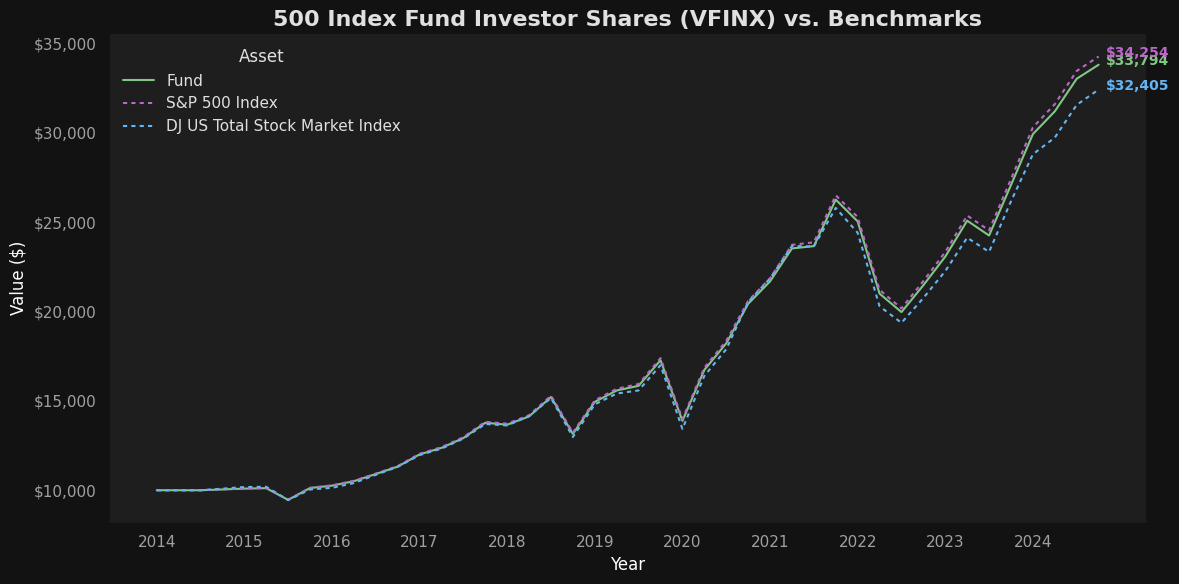

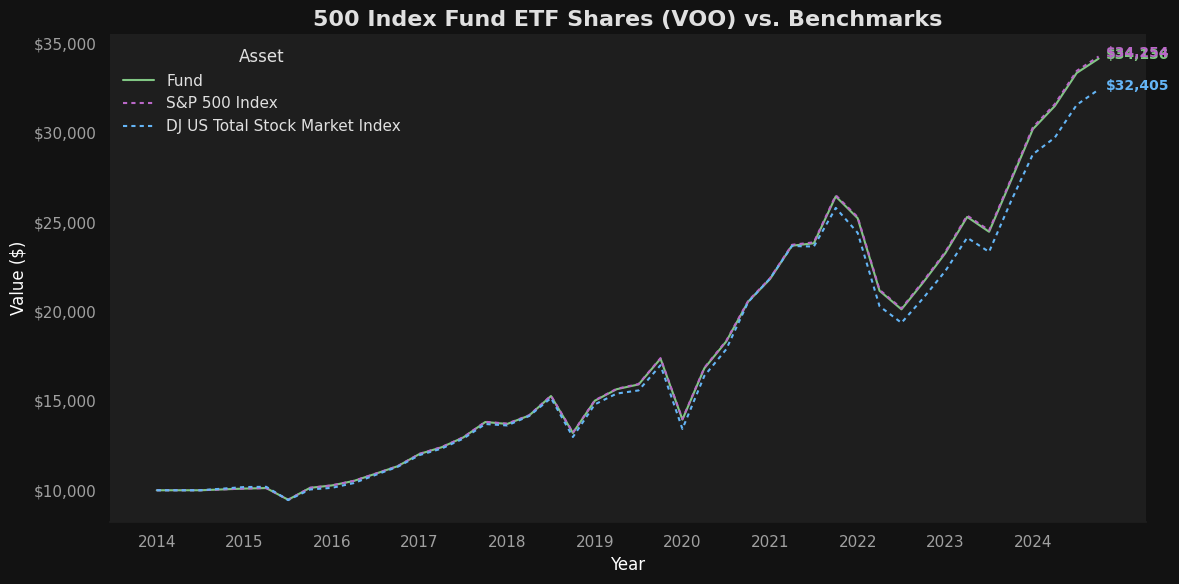

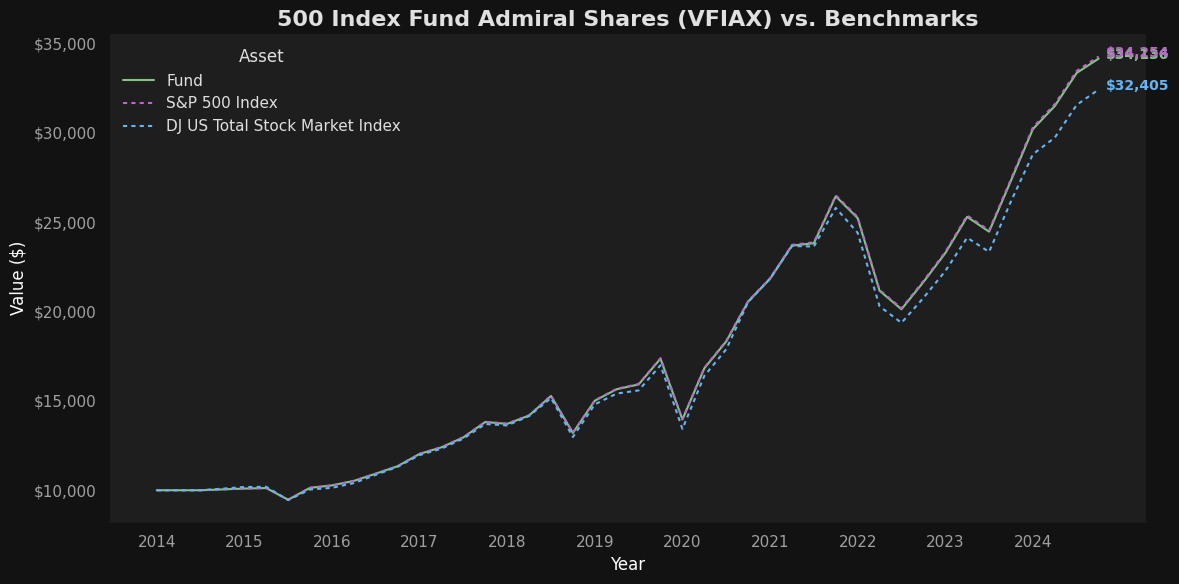

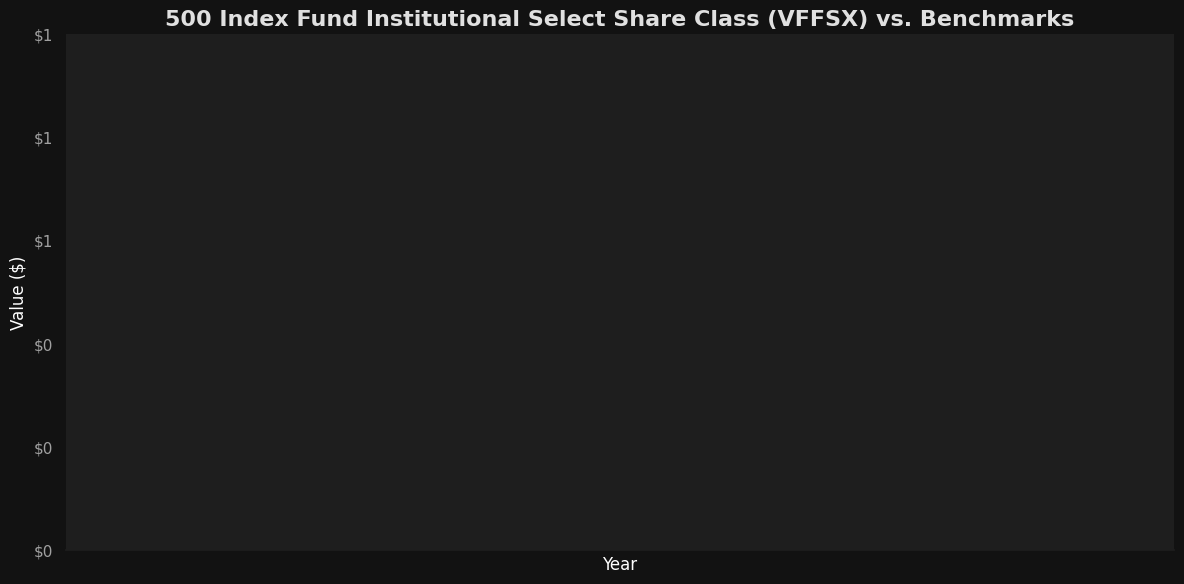

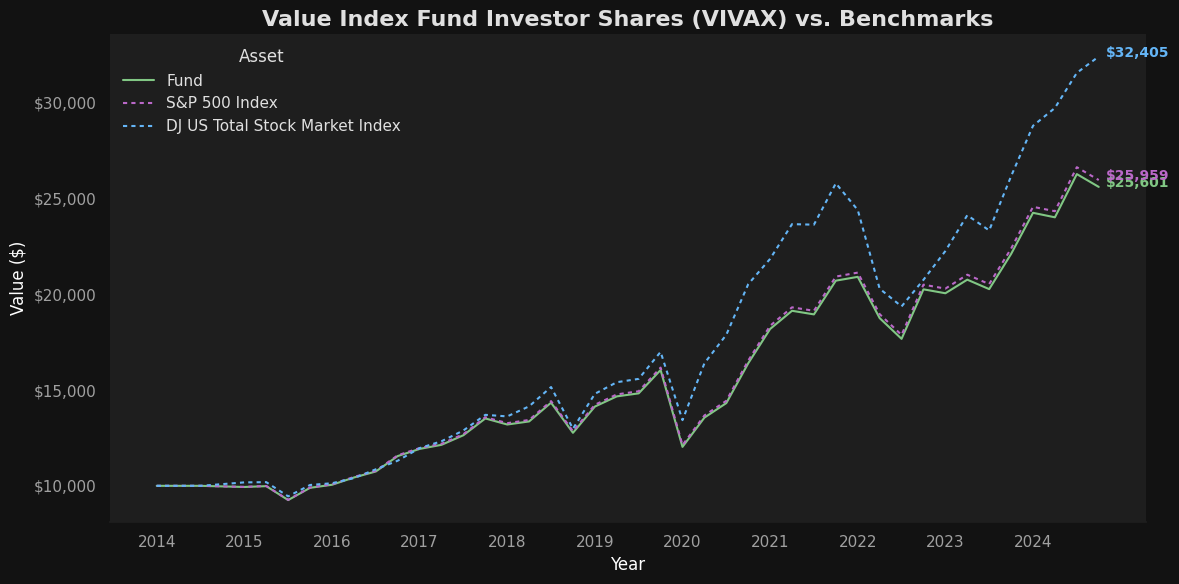

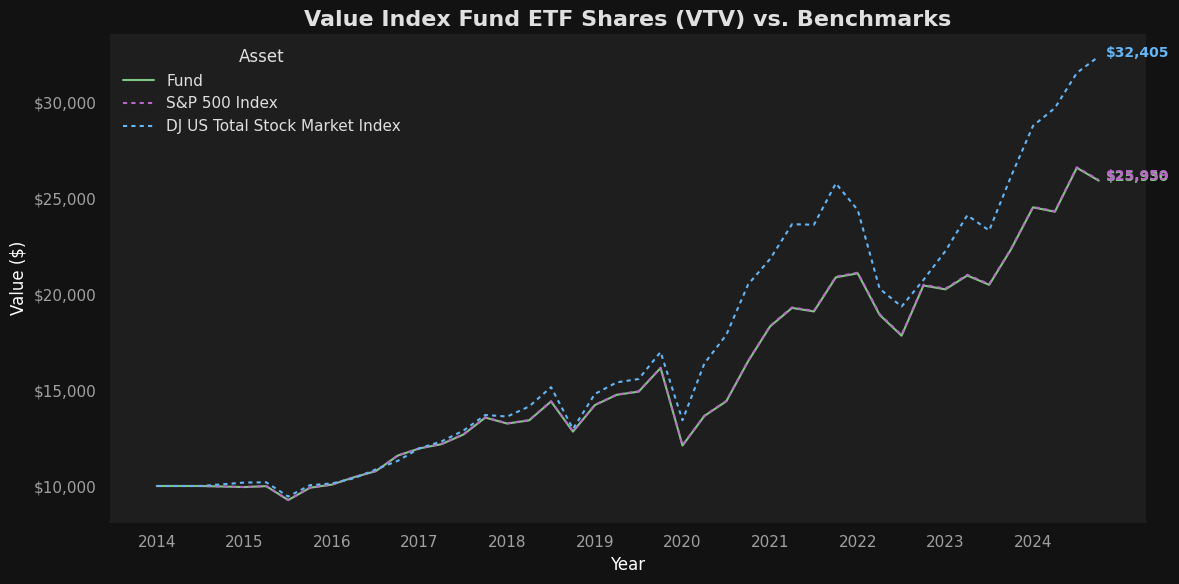

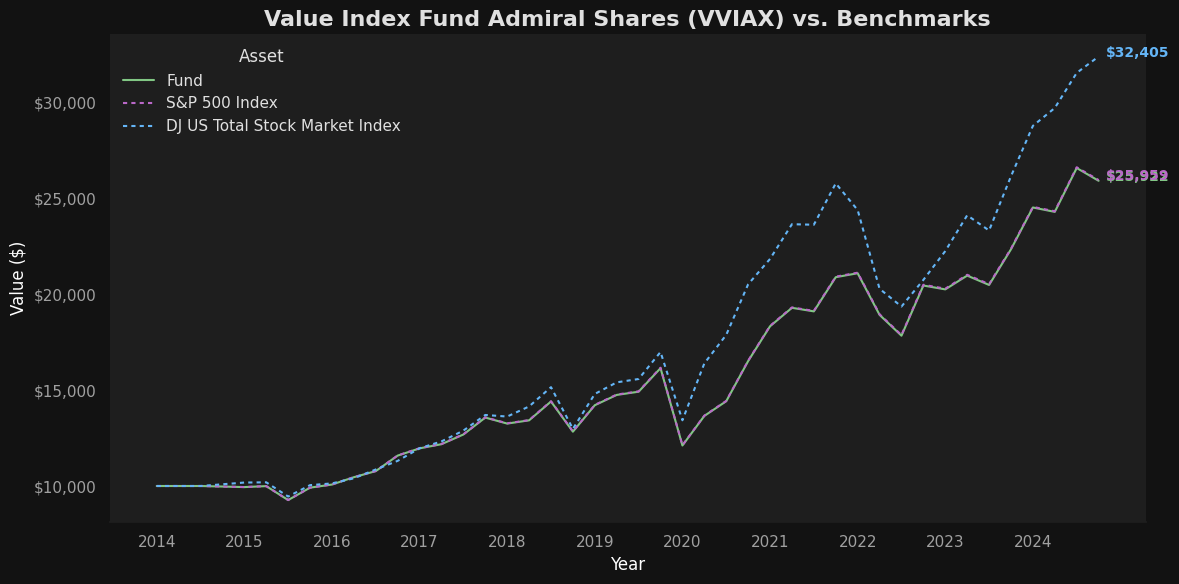

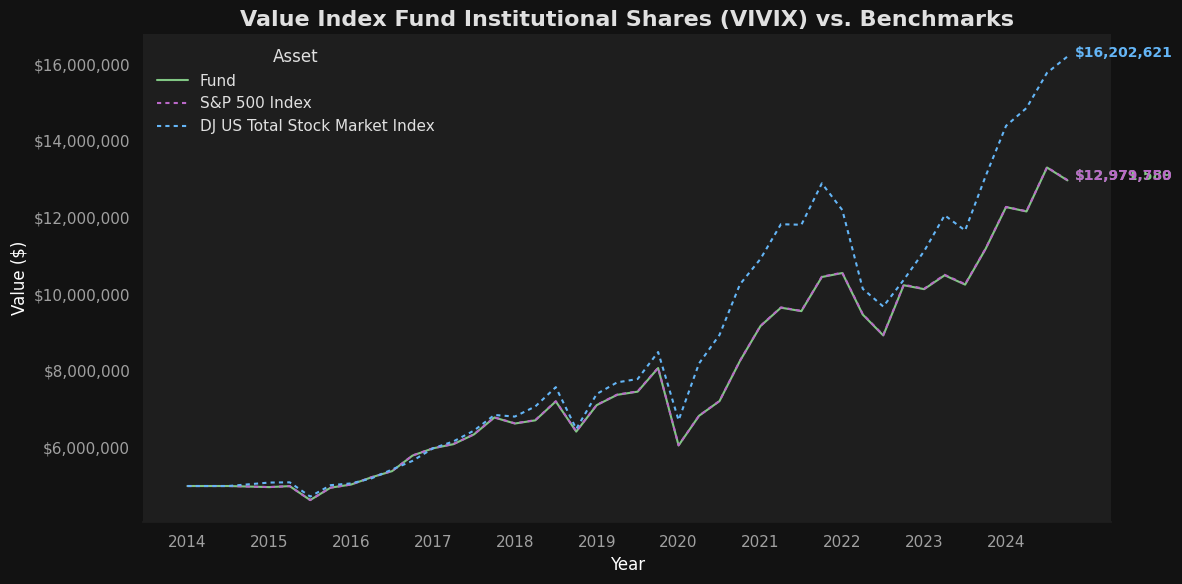

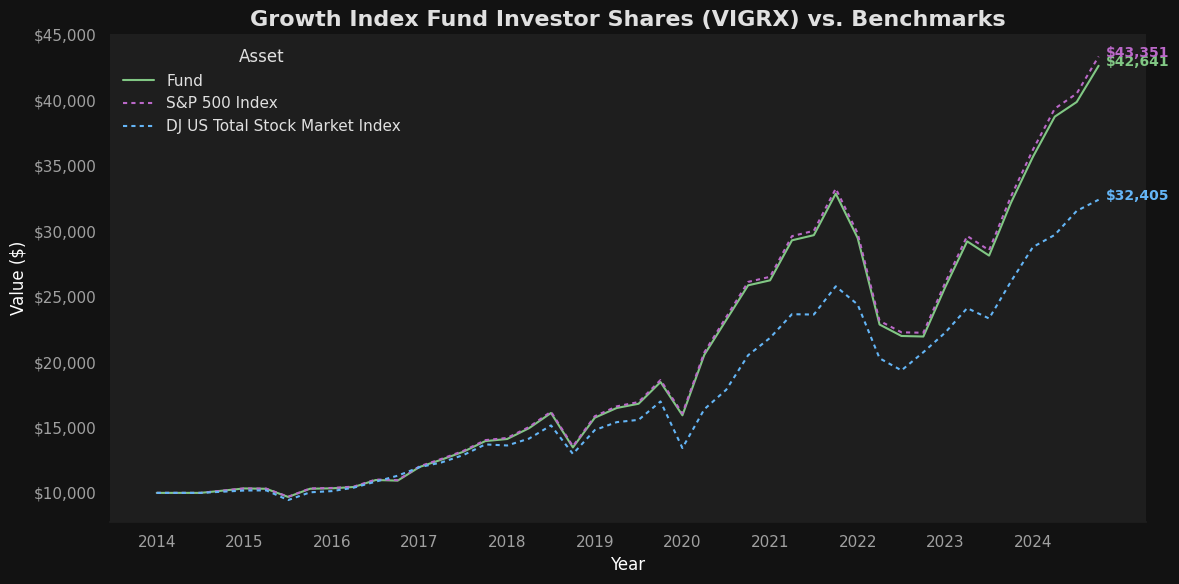

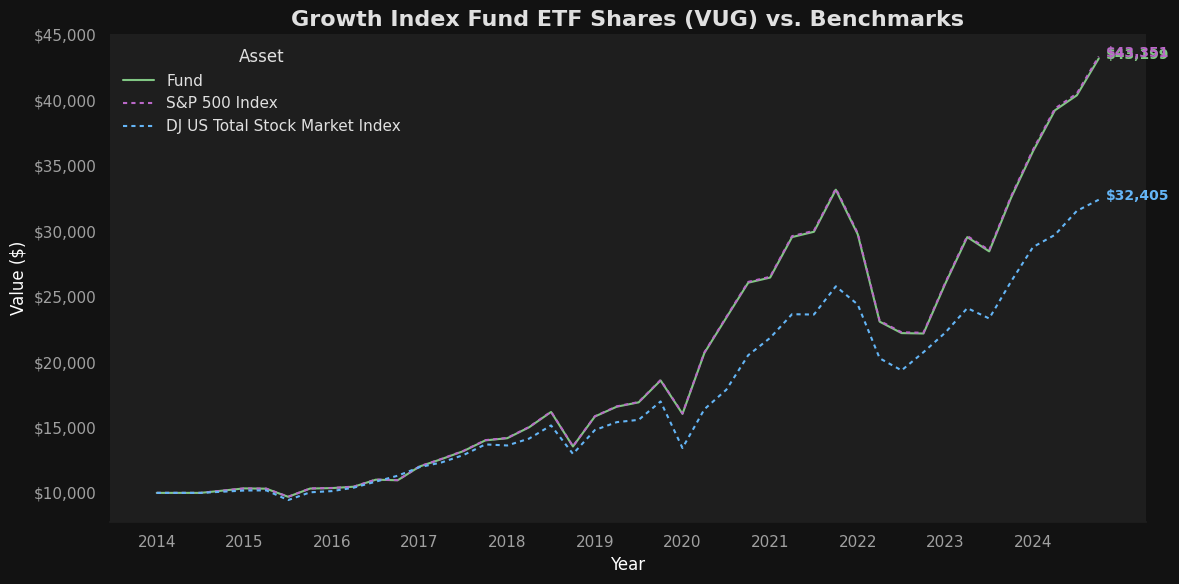

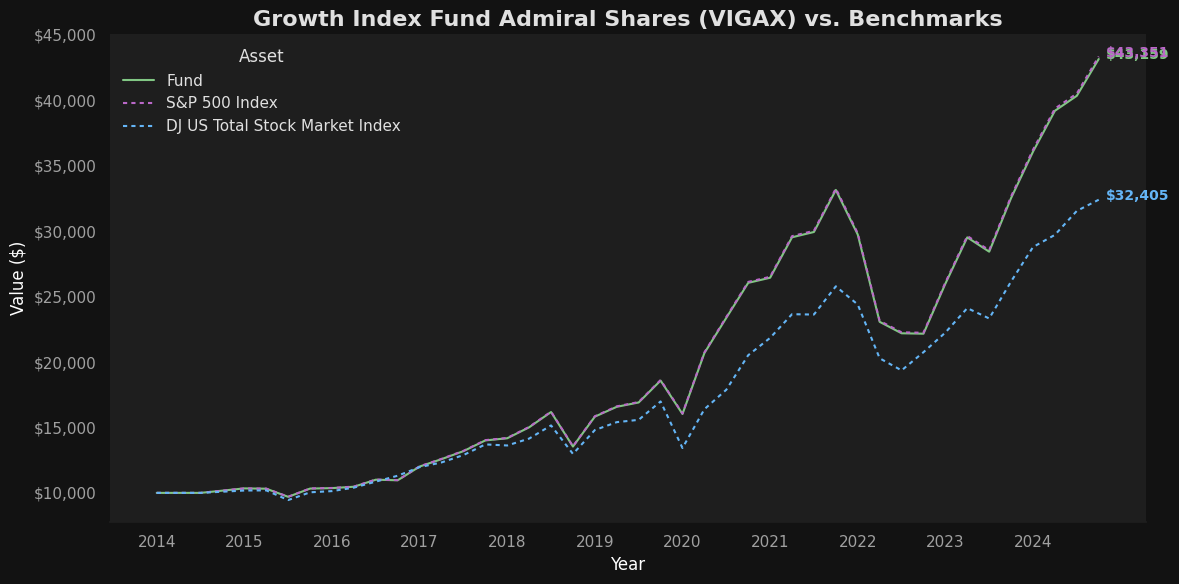

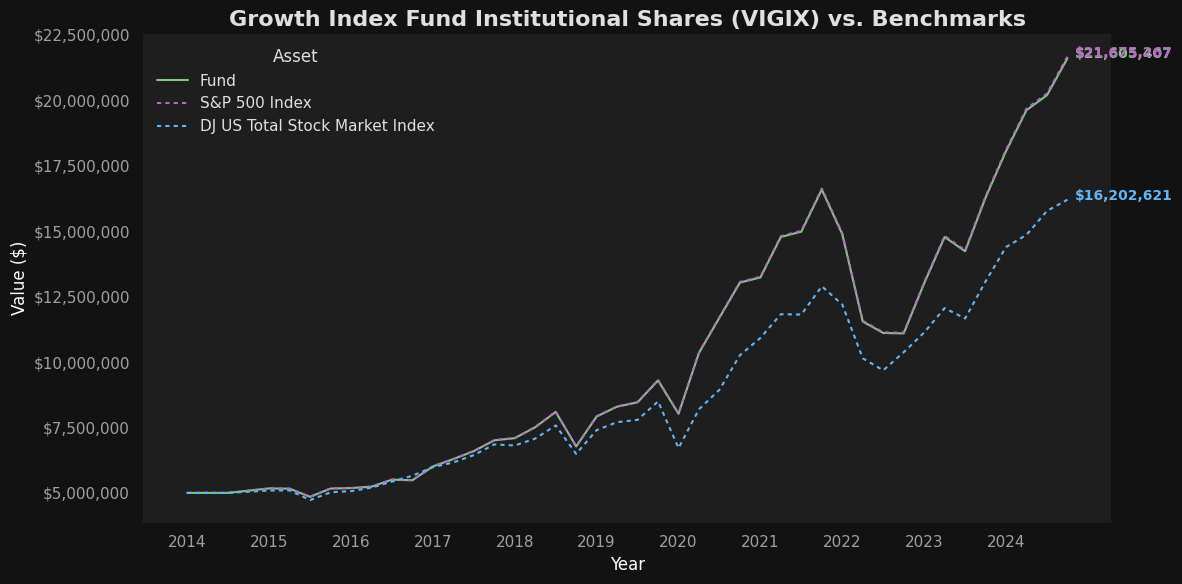

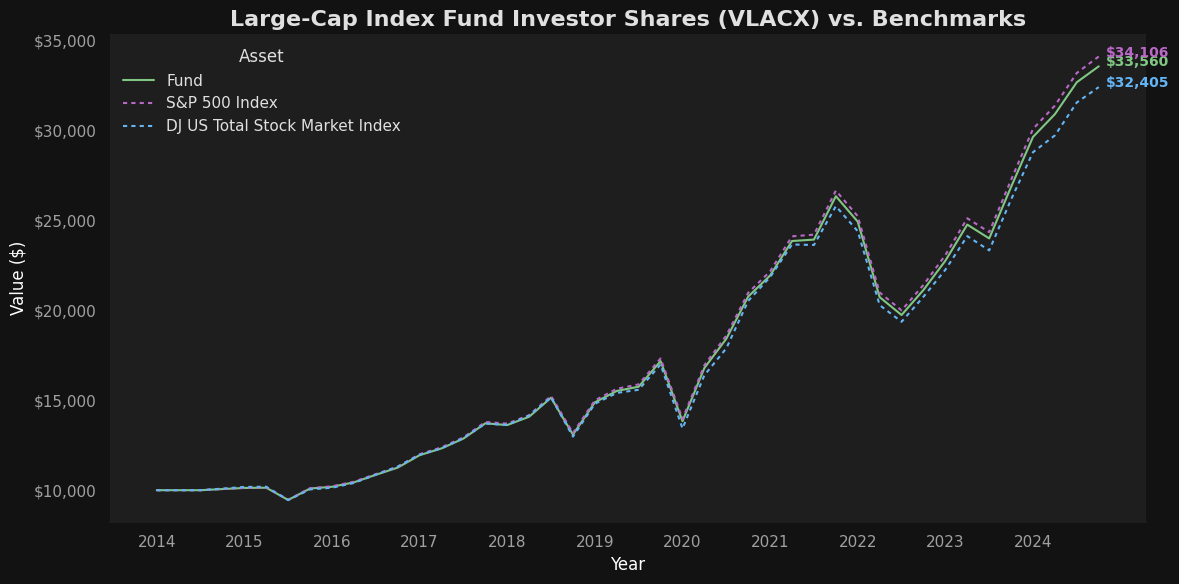

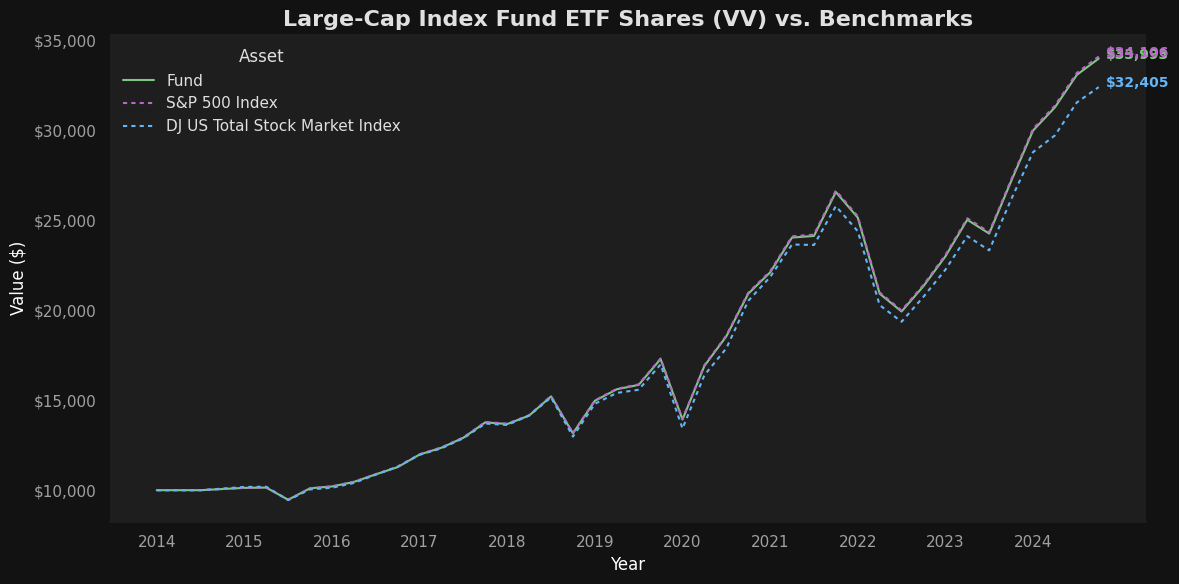

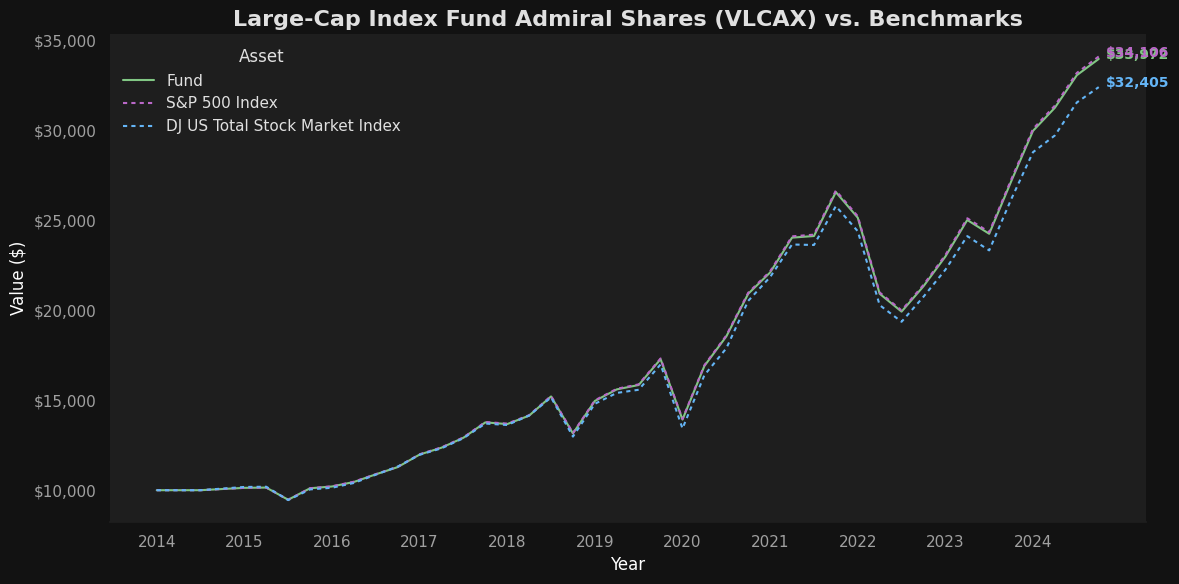

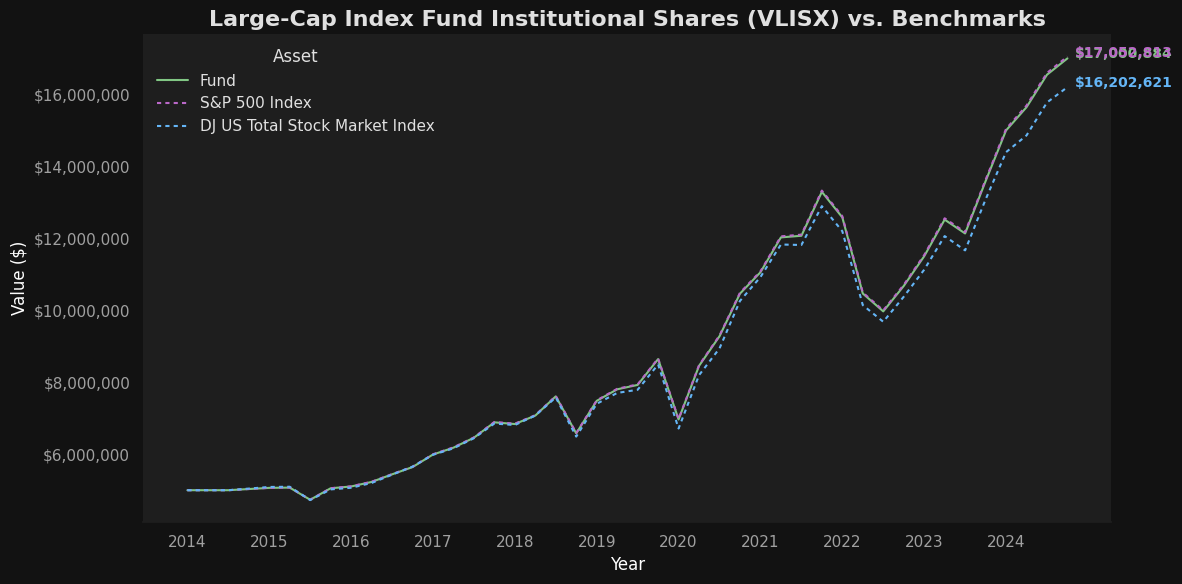

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
from io import StringIO


def prepare_chart_data(df_raw):
    df = df_raw.copy()
    df.columns = ['Date', 'Fund', 'S&P 500 Index', 'DJ US Total Stock Market Index']
    
    # 1. FIX: Convert Date to numeric immediately
    df['Date'] = pd.to_numeric(df['Date'], errors='coerce')
    
    # 2. Clean the other columns
    for col in ['Fund', 'S&P 500 Index', 'DJ US Total Stock Market Index']:
        df[col] = df[col].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce') 
        
    # Drop rows with missing data
    df.dropna(subset=['Date', 'Fund', 'S&P 500 Index', 'DJ US Total Stock Market Index'], inplace=True)

    # 3. Calculate Decimal Year
    df['cumcount'] = df.groupby('Date').cumcount()
    df['count'] = df.groupby('Date')['Date'].transform('count')
    
    # Now this works because 'Date' is a number (2014) + float (0.0)
    df['DecimalDate'] = df['Date'] + (df['cumcount'] / df['count'])
        
    df_long = df.melt(id_vars=['Date', 'DecimalDate'], 
                      value_vars=['Fund', 'S&P 500 Index', 'DJ US Total Stock Market Index'],
                      var_name='Asset', 
                      value_name='Value')
    
    return df_long

def generate_seaborn_chart(df_long, ticker="Fund", output_path="./10k_images/"):
    plt.style.use('dark_background')
    
    # Custom rcParams for the "Terminal" look
    plt.rcParams.update({
        "axes.facecolor": "#1e1e1e",
        "figure.facecolor": "#121212",
        "grid.color": "#444444",
        "grid.linestyle": ":",
        "axes.edgecolor": "#1e1e1e", # Hide borders
        "text.color": "#e0e0e0",
        "xtick.color": "#a0a0a0",
        "ytick.color": "#a0a0a0"
    })
    fig, ax = plt.subplots(figsize=(12, 6))
    custom_colors = ["#81c784", "#ba68c8", "#64b5f6", "#ffb74d"]
    sns.set_palette(sns.color_palette(custom_colors))
    assets = df_long['Asset'].unique()
    dash_styles = {}
    for asset in assets:
        
        if "Fund" in asset: # Check if this is the main fund
            dash_styles[asset] = ""      # Solid line
        else:
            dash_styles[asset] = (2, 2)  # Discontinuous line

    # --- 3. PLOT WITH STYLE ---
    sns.lineplot(
        data=df_long, 
        x='DecimalDate', 
        y='Value', 
        hue='Asset', 
        style='Asset',        # Group styles by Asset
        dashes=dash_styles,   # Apply our custom solid/dashed logic
        linewidth=1.5,        # Thin lines
        ax=ax
    )

    ax.set_title(f"{ticker} vs. Benchmarks", fontsize=16, weight='bold')
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Value ($)", fontsize=12)
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    unique_years = df_long['Date'].unique()
    ax.set_xticks(unique_years)
    ax.set_xticklabels(unique_years)

    last_points = df_long.loc[df_long.groupby('Asset')['DecimalDate'].idxmax()]
    asset_order = df_long['Asset'].unique().tolist()
    for i, row in last_points.iterrows():
        line_color = ax.get_lines()[asset_order.index(row['Asset'])].get_color()
        ax.annotate(f"${row['Value']:,.0f}", 
                    xy=(row['DecimalDate'], row['Value']),
                    xytext=(5, 0), textcoords='offset points',
                    fontsize=10, color=line_color, weight='bold')
    
    plt.tight_layout()
    plt.savefig(output_path + ticker + ".png", dpi=300)
    

# --- Generate Chart ---

OUTPUT_PATH = "./10k_images_vs_benchmarks/"
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
os.makedirs(OUTPUT_PATH, exist_ok=True)

for fund in funds_data:
    try:
        df = pd.DataFrame(fund['table_data'])
        first_column = df.columns[0]
        df.rename(columns={first_column: 'Date'}, inplace=True)
        row_2014 = df[df['Date'] == 2014]
        df_prepared = pd.concat([row_2014, df], ignore_index=True)
        df_ready = prepare_chart_data(df_prepared)
        generate_seaborn_chart(df_ready, ticker=f"{fund['name']} {fund['share_class']} ({fund['ticker']})", output_path=OUTPUT_PATH + fund['name'])
        
    except Exception as e:
        print(f"Error processing {fund['name']}: {str(e)}")

In [ ]:
history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Capital Gains'],
      dtype='object')

In [ ]:


# --- Prepare Data with DecimalDate Logic ---

for fund in funds_data:
    df = pd.DataFrame(funds_data[0]['table_data'])
    first_column = df.columns[0]
    df.rename(columns={first_column: 'Date'}, inplace=True)
    

NameError: name 'funds_data' is not defined

We also would like to obtain the images from the filing.

In [50]:
from edgar import Company, set_identity

# 1. Initialize the company using its Ticker or CIK
# Replace 'VFINX' with your fund's ticker
set_identity("luis.alvarez.conde@alumnos.upm.es")

fund = Company("VOO") 

# 2. Fetch all filings filtered by form 'NPORT-P'
# NPORT-P is the public version of the monthly portfolio holdings
nport_filings = fund.get_filings(form="NPORT-P")
same_date = 0
# 3. Get the absolutely latest filing
latest_nport = nport_filings.latest()


for f in nport_filings:
    if f.filing_date == latest_nport.filing_date:
        same_date += 1

print("Number of filings with the same date: ", same_date)
# 4. Verify the date and accession number
print(f"Latest NPORT Date: {latest_nport.filing_date}")
print(f"Accession Number: {latest_nport.accession_number}")

# 5. (Optional) Open the XML immediately
fund_report = latest_nport.obj()






Number of filings with the same date:  12
Latest NPORT Date: 2025-08-27
Accession Number: 0000036405-25-000136


In [17]:
fund_report

CUSIP ticker resolution failed for 087CNT010: '087CNT010'
CUSIP ticker resolution failed for 294ESC017: '294ESC017'
CUSIP ticker resolution failed for 361ESC049: '361ESC049'
CUSIP ticker resolution failed for 68218J202: '68218J202'
CUSIP ticker resolution failed for 62855X103: '62855X103'
CUSIP ticker resolution failed for 554991893: '554991893'
CUSIP ticker resolution failed for 641ESC017: '641ESC017'
CUSIP ticker resolution failed for 68218J301: '68218J301'
CUSIP ticker resolution failed for 09175M887: '09175M887'
CUSIP ticker resolution failed for 05581M503: '05581M503'
CUSIP ticker resolution failed for 029CNT029: '029CNT029'
CUSIP ticker resolution failed for 02503H209: '02503H209'


╭───────────────────── VANGUARD INDEX FUNDS - VANGUARD EXTENDED MARKET INDEX FUND 2025-06-30 ─────────────────────╮
│                                      Financials                                                                 │
│                                                                                                                 │
│   Assets             Liabilities   Net Assets         Total Positions   Derivatives                             │
│  ───────────────────────────────────────────────────────────────────────────────────                            │
│   $113,117,501,315   $87,334,664   $113,030,166,651   3429              6                                       │
│                                                                                                                 │
│                       Interest Rate Sensitivity                                                                 │
│                                                                       

In [18]:

for attr in dir(fund_report):
    if not attr.startswith("_"):
        print(attr)


credit_spread_table
derivatives
derivatives_data
derivatives_table
forwards_data
from_filing
fund_company
fund_info
fund_info_table
fund_summary_table
futures_data
general_info
get_base_derivative_data
get_fund_series
get_ticker_for_series
has_investments
header
investment_data
investments
investments_table
matches_ticker
metrics_table
name
non_derivatives
options_data
parse_fund_xml
reporting_period
securities_data
swaps_data
swaptions_data


In [47]:
fund_report.general_info

GeneralInfo(name='VANGUARD INDEX FUNDS', cik='0000036405', file_number='811-02652', reg_lei='549300G6KNDK44WUN559', street1='100 Vanguard Boulevard', street2=None, city='Malvern', state='US-PA', country='US', zip_or_postal_code='19355', phone='610-669-1000', series_name='VANGUARD EXTENDED MARKET INDEX FUND', series_lei='NKRB5RF4FYYMQPL0SY31', series_id='S000002841', fiscal_year_end='2025-12-31', rep_period_date='2025-06-30', is_final_filing=False)

In [49]:
import json 

from decimal import Decimal

def best_identifier(inv):
    ids = inv.identifiers
    if getattr(ids, "isin", None):
        return ids.isin
    if getattr(inv, "cusip", None):
        return inv.cusip
    if getattr(ids, "ticker", None):
        return ids.ticker
    if getattr(inv, "lei", None):
        return inv.lei
    return None


def to_float(x):
    return float(x) if isinstance(x, Decimal) else x

    
def holding_minimal_json(inv):
    return {
        "name": inv.name,
        "identifier": best_identifier(inv),
        "balance": to_float(inv.balance),
        "units": inv.units,
        "currency": inv.currency_code,
        "value_usd": to_float(inv.value_usd),
        "pct_value": to_float(inv.pct_value),
        "investment_country": inv.investment_country,
        "fair_value_level": int(inv.fair_value_level)
            if inv.fair_value_level is not None else None,
    }
investment_list = fund_report.investments
OUTPUT_PATH = "edgar_output/investments/"
investments = []
fund = {}
fund['name'] = fund_report.general_info.series_name

for investment in investment_list:
    investments.append(holding_minimal_json(investment))

fund['investments'] = investments
print(json.dumps(fund))


{"name": "VANGUARD EXTENDED MARKET INDEX FUND", "investments": [{"name": "Surgery Partners Inc", "identifier": "US86881A1007", "balance": 1158355.0, "units": "NS", "currency": "USD", "value_usd": 25750231.65, "pct_value": 0.022781733773, "investment_country": "US", "fair_value_level": 1}, {"name": "ExlService Holdings Inc", "identifier": "US3020811044", "balance": 2512785.0, "units": "NS", "currency": "USD", "value_usd": 110034855.15, "pct_value": 0.097349989308, "investment_country": "US", "fair_value_level": 1}, {"name": "Six Flags Entertainment Corp", "identifier": "US83001C1080", "balance": 1452655.0, "units": "NS", "currency": "USD", "value_usd": 44204291.65, "pct_value": 0.03910840173, "investment_country": "US", "fair_value_level": 1}, {"name": "Cingulate Inc", "identifier": "US17248W3034", "balance": 35377.0, "units": "NS", "currency": "USD", "value_usd": 143984.39, "pct_value": 0.000127385807, "investment_country": "US", "fair_value_level": 1}, {"name": "Smith-Midland Corp", "